In [1]:
import transformers

from transformers import AutoTokenizer,TFAutoModelForSequenceClassification

import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm


2024-02-15 14:31:52.144125: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 14:31:52.144182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 14:31:52.145627: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# pip install numpy==1.23.4

In [3]:
DATA_PATH = "/kaggle/input/pridemine/Pride.csv"

In [4]:
df = pd.read_csv(DATA_PATH)
df.head()

,name,hate,target,stance,humour,split,text
0,img_1.png,0,NaN,0,1,train,transgirls who grow boobs but keep their cock ...
1,img_2.png,1,2.0,0,1,test,imagine only being able to date this meme was ...
2,img_3.png,0,NaN,1,0,train,soon available on every women's bathroom say t...
3,img_4.png,0,NaN,1,0,train,realistic and wholesome representation of tran...
4,img_5.png,0,NaN,0,1,train,united lgbt united sponsored you can color you...


In [5]:
# check the size of the data
print("Train data size \n", df.shape )


Train data size 
 (5063, 7)


In [6]:
baseModel = 'bert-base-uncased'
task = 'hate'
num_labels = 2
lr = 5e-5
epochs = 3
# to_remove = ['index', 'name', 'hate', 'target', 'humour', 'split', 'text', 'count'] #stance
to_remove = ['index', 'name', 'target', 'stance', 'humour', 'split', 'text', 'count'] #hate
# to_remove = ['index', 'name', 'hate', 'stance', 'humour', 'split', 'text', 'count'] #target
# to_remove = ['index', 'name', 'hate', 'stance', 'target', 'split', 'text', 'count'] #humour

In [7]:
import numpy as np

# if task == 'target':
#     df = df[df['hate'] == 1].reset_index(drop=True)

if task == 'target':
    df[task] = df[task].replace(' ', np.nan)
    df.dropna(subset=[task],inplace=True)


print(df.shape)

# df = df[df['Hate'] != 0]

# print(df.shape)

(5063, 7)


In [8]:
# reset the indexing after droping the rows

df.reset_index(inplace=True)

In [9]:
df[task] = pd.to_numeric(df[task],downcast='integer')

In [10]:
df.shape

(5063, 8)

In [11]:
df['count'] = df['text'].apply(lambda x: len(x.split()))

In [12]:


category_count = df[task].value_counts()

categories = category_count.index

categories



Index([0, 1], dtype='int8', name='hate')

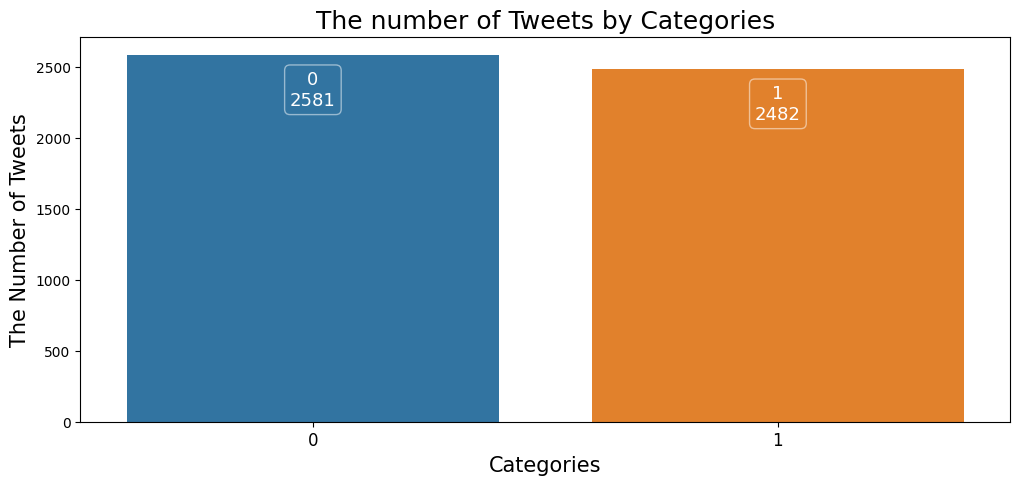

In [13]:


fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of Tweets', size= 15)

plt.xticks(size = 12)

plt.title("The number of Tweets by Categories" , size = 18)

plt.show()



In [14]:
from datasets import Dataset, DatasetDict

ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['index', 'name', 'hate', 'target', 'stance', 'humour', 'split', 'text', 'count'],
    num_rows: 5063
})

In [15]:
train_test_valid = ds.train_test_split(test_size =0.15)

test_valid = train_test_valid['test'].train_test_split(test_size=0.5)

train_test_valid_dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
    })


ds = train_test_valid_dataset
ds

DatasetDict({
    train: Dataset({
        features: ['index', 'name', 'hate', 'target', 'stance', 'humour', 'split', 'text', 'count'],
        num_rows: 4303
    })
    test: Dataset({
        features: ['index', 'name', 'hate', 'target', 'stance', 'humour', 'split', 'text', 'count'],
        num_rows: 380
    })
    valid: Dataset({
        features: ['index', 'name', 'hate', 'target', 'stance', 'humour', 'split', 'text', 'count'],
        num_rows: 380
    })
})

In [16]:
tokenizer = AutoTokenizer.from_pretrained(baseModel)

In [17]:
print(f"Vocab size is : {tokenizer.vocab_size}")

print(f"Model max length is : {tokenizer.model_max_length}")

print(f"Model input names are: {tokenizer.model_input_names}")

Vocab size is : 30522
Model max length is : 512
Model input names are: ['input_ids', 'token_type_ids', 'attention_mask']


In [18]:
tokenizer.model_max_length = 256
tokenizer.model_max_length

256

In [19]:
def tokenize_function(train_dataset):
    return tokenizer(train_dataset['text'], padding='max_length', truncation=True)

tokenized_dataset = ds.map(tokenize_function, batched=True)

tokenized_dataset

train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['valid']
test_dataset = tokenized_dataset['test']

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [20]:
train_dataset

Dataset({
    features: ['index', 'name', 'hate', 'target', 'stance', 'humour', 'split', 'text', 'count', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4303
})

In [21]:


train_set = train_dataset.remove_columns(to_remove).with_format('tensorflow')

tf_eval_dataset = eval_dataset.remove_columns(to_remove).with_format('tensorflow')

tf_test_dataset = test_dataset.remove_columns(to_remove).with_format('tensorflow')

In [22]:
train_set

Dataset({
    features: ['hate', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4303
})

In [23]:
train_features = { x: train_set[x] for x in tokenizer.model_input_names  }

train_set_for_final_model = tf.data.Dataset.from_tensor_slices((train_features, train_set[task] ))

train_set_for_final_model = train_set_for_final_model.shuffle(len(train_set)).batch(16)


eval_features = {x: tf_eval_dataset[x] for x in tokenizer.model_input_names}
val_set_for_final_model = tf.data.Dataset.from_tensor_slices((eval_features, tf_eval_dataset[task]))
val_set_for_final_model = val_set_for_final_model.batch(16)

test_features = {x: tf_test_dataset[x] for x in tokenizer.model_input_names}
test_set_for_final_model = tf.data.Dataset.from_tensor_slices((test_features, tf_test_dataset[task]))
test_set_for_final_model =test_set_for_final_model.batch(16)

In [24]:
train_set[task]

<tf.Tensor: shape=(4303,), dtype=int64, numpy=array([1, 1, 1, ..., 0, 0, 0])>

In [25]:
pip install livelossplot

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [26]:
import keras
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow as tf

In [27]:
from livelossplot import PlotLossesKeras
callbacks = [PlotLossesKeras()]

In [28]:
model = TFAutoModelForSequenceClassification.from_pretrained(baseModel,num_labels=num_labels)



All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# # setting up class weights for imbalanced data

# import numpy as np

# from sklearn.utils import class_weight
# class_weight = class_weight.compute_class_weight('balanced'
#                                                ,classes = np.unique(train_dataset[task])
#                                                ,y = train_dataset[task])

In [30]:
# class_weight

In [31]:
# class_weights = dict(zip(np.unique(train_dataset[task]), class_weight))
# class_weights

In [32]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


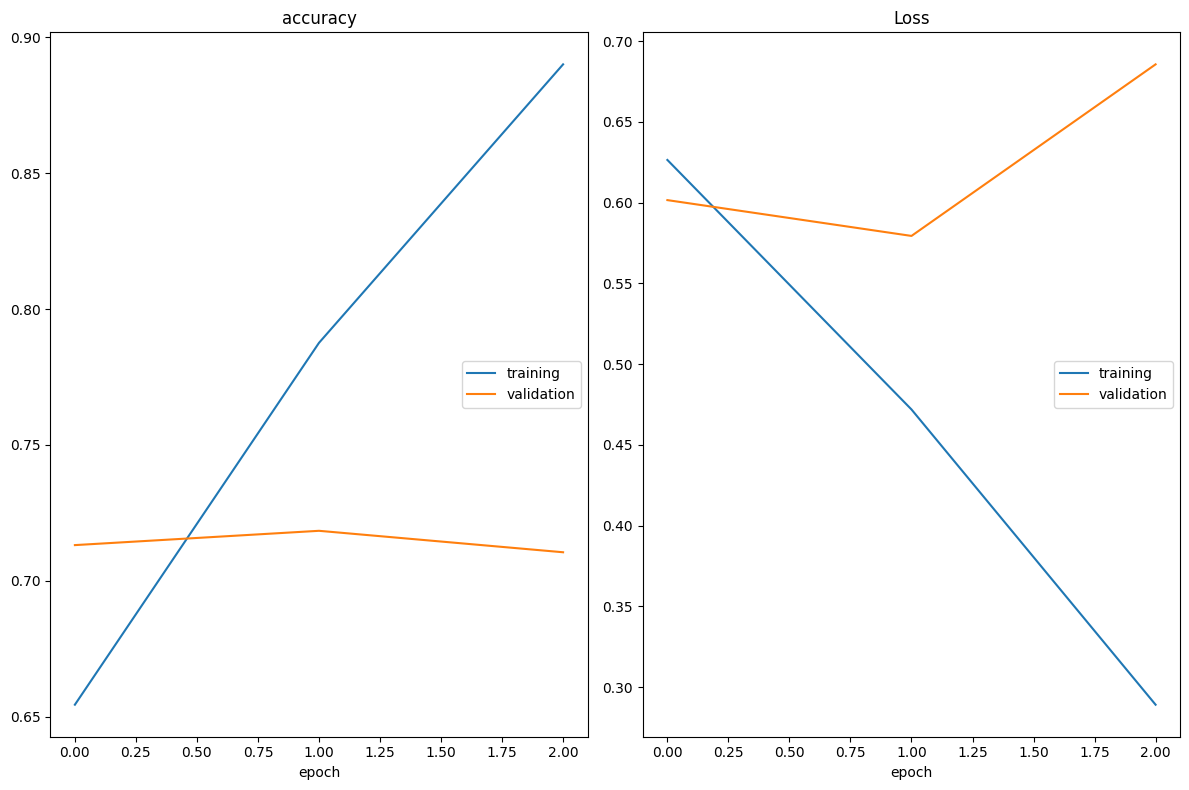

accuracy
	training         	 (min:    0.654, max:    0.890, cur:    0.890)
	validation       	 (min:    0.711, max:    0.718, cur:    0.711)
Loss
	training         	 (min:    0.289, max:    0.626, cur:    0.289)
	validation       	 (min:    0.579, max:    0.686, cur:    0.686)
269/269 [==============================] - 228s 849ms/step - loss: 0.2891 - accuracy: 0.8901 - val_loss: 0.6856 - val_accuracy: 0.7105


In [33]:
# history = model.fit(train_set_for_final_model, validation_data=val_set_for_final_model, epochs=5, class_weight=class_weights,callbacks=[callbacks],verbose=1 )

history = model.fit(train_set_for_final_model, validation_data=val_set_for_final_model, epochs=epochs,callbacks=[callbacks],verbose=1 )


In [34]:
results = model.evaluate(test_set_for_final_model,verbose=1)
print(results)

24/24 [==============================] - 7s 291ms/step - loss: 0.6586 - accuracy: 0.7132
[0.6585824489593506, 0.7131578922271729]


In [35]:
preds = model.predict(test_set_for_final_model,verbose=1)

24/24 [==============================] - 10s 286ms/step


In [36]:
# preds

# predss = [tf.nn.softmax(i) for i in preds.logits]

predss = tf.nn.softmax(preds.logits)

# predss

In [37]:
# import numpy as np

# preds.logits

# for i in range(len(preds['logits'])):
#   p = np.argmax(preds['logits'][i])
#   print(p)

In [38]:
# model.save('/content/gdrive/MyDrive/FFF/bert_relevance')

In [39]:
len(preds['logits'])

380

In [40]:
test_labels = test_valid['test'][task]



In [41]:
preds_labels = []
for i in range(len(preds['logits'])):
  p = np.argmax(preds['logits'][i])
  preds_labels.append(p)


In [42]:
print(np.array(preds_labels).shape)
print(np.array(test_labels).shape)

(380,)
(380,)


In [43]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.metrics import macro_averaged_mean_absolute_error

# print("Seed -->", seed )
# print("Hate Targets ClimateBert")
print("Task -->", task)

print("Accuracy -> ",accuracy_score(preds_labels, test_labels))
print("F1 score -> ",f1_score(preds_labels, test_labels,average='macro'))
print("Macro MAE -> ",macro_averaged_mean_absolute_error(preds_labels, test_labels))
print("Recall -> ",recall_score(preds_labels, test_labels,average='macro'))
print("Precision -> ",precision_score(preds_labels, test_labels,average='macro'))
# print("AUC -> ",roc_auc_score(test_labels, predss, average='macro', multi_class='ovo'))
# print("AUC -> ",roc_auc_score(test_labels, predss, average='macro'))

print(confusion_matrix(preds_labels, test_labels))

print(classification_report(preds_labels, test_labels))

Task --> hate
Accuracy ->  0.7131578947368421
F1 score ->  0.7131559082819132
Macro MAE ->  0.2868084988503836
Recall ->  0.7131915011496164
Precision ->  0.7132092198581561
[[136  53]
 [ 56 135]]
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       189
           1       0.72      0.71      0.71       191

    accuracy                           0.71       380
   macro avg       0.71      0.71      0.71       380
weighted avg       0.71      0.71      0.71       380

